# Model Explainability with SHAP and Feature Importance

This notebook loads a trained LightGBM model and a test dataset, then generates:

- Feature importance plot
- SHAP summary plot (global explanations)
- SHAP waterfall plot (local explanation for one instance)
- SHAP force plot (interactive local explanation)

All figures are saved under the `figures/` folder.

##  1: Imports and Setup

This cell imports all the necessary Python libraries for model explainability. I use joblib to load the saved LightGBM model, pandas for data manipulation, matplotlib and seaborn for plotting, and shap for SHAP explainability. I also create a folder named figures to save all generated plots and initialize SHAP's JavaScript visualization support for interactive plots in Jupyter.

In [13]:
import os
import joblib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

# Create output directory for figures
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# Enable JS visualization for SHAP 
shap.initjs()

## 2: Load model and data
Here, I load the pre-trained LightGBM model from a file and read the dataset CSV file into a DataFrame. I separate the features (X) by dropping the target column. This prepares our environment for generating explainability visualizations. The data shape is printed to confirm successful loading.

In [14]:
model_path = r"C:\Users\hp\Desktop\10 Acadamy\VS code\credit-fraud-detection\outputs\models\best_model.pkl"
data_path = r"C:\Users\hp\Desktop\10 Acadamy\VS code\credit-fraud-detection\data\processed\final_model_input.csv"
target_col = "class"

def load_model_and_data(model_path, data_path, target_col):
    print("🔄 Loading model and data...")
    model = joblib.load(r"C:\Users\hp\Desktop\10 Acadamy\VS code\credit-fraud-detection\outputs\models\best_model.pkl")
    df = pd.read_csv(data_path)
    X = df.drop(columns=[target_col])
    print(f"✅ Model and data loaded. Data shape: {X.shape}")
    return model, X

model, X = load_model_and_data(model_path, data_path, target_col)


🔄 Loading model and data...
✅ Model and data loaded. Data shape: (434838, 51)


## 3: Plot feature importance (top 20 features)
This cell generates a bar chart showing the top 20 most important features according to the LightGBM model’s built-in feature importance metric. It helps us understand which features the model relied on most during training to make predictions. The plot is saved to the figures directory.

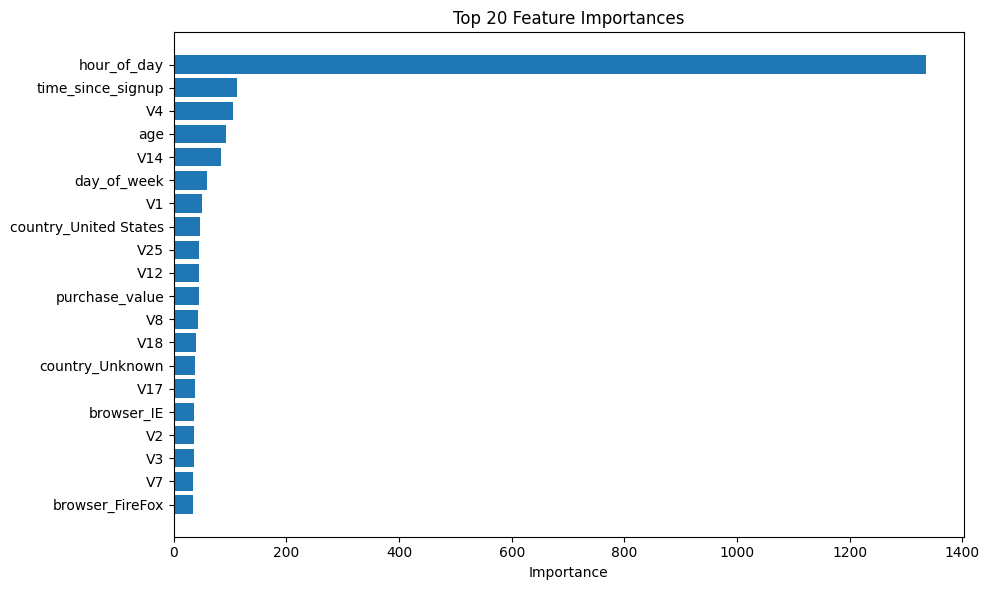

✅ Feature importance saved to: figures\feature_importance.png


In [15]:
def plot_feature_importance(model, X, output_dir):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:20]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices][::-1], align="center")
    plt.yticks(range(len(indices)), X.columns[indices][::-1])
    plt.xlabel("Importance")
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    save_path = os.path.join(output_dir, "feature_importance.png")
    plt.savefig(save_path)
    plt.show()
    print(f"✅ Feature importance saved to: {save_path}")

plot_feature_importance(model, X, output_dir)


## 4: SHAP summary plot (global explanation)
Using SHAP’s TreeExplainer, this cell computes SHAP values for a sample of 50 rows from the dataset and generates a summary plot. This visualization reveals how each feature impacts the model output across many samples, showing both the magnitude and direction (positive or negative) of influence. This provides a detailed global explanation of model behavior.

🔄 Starting SHAP summary plot...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


✅ SHAP values computed.


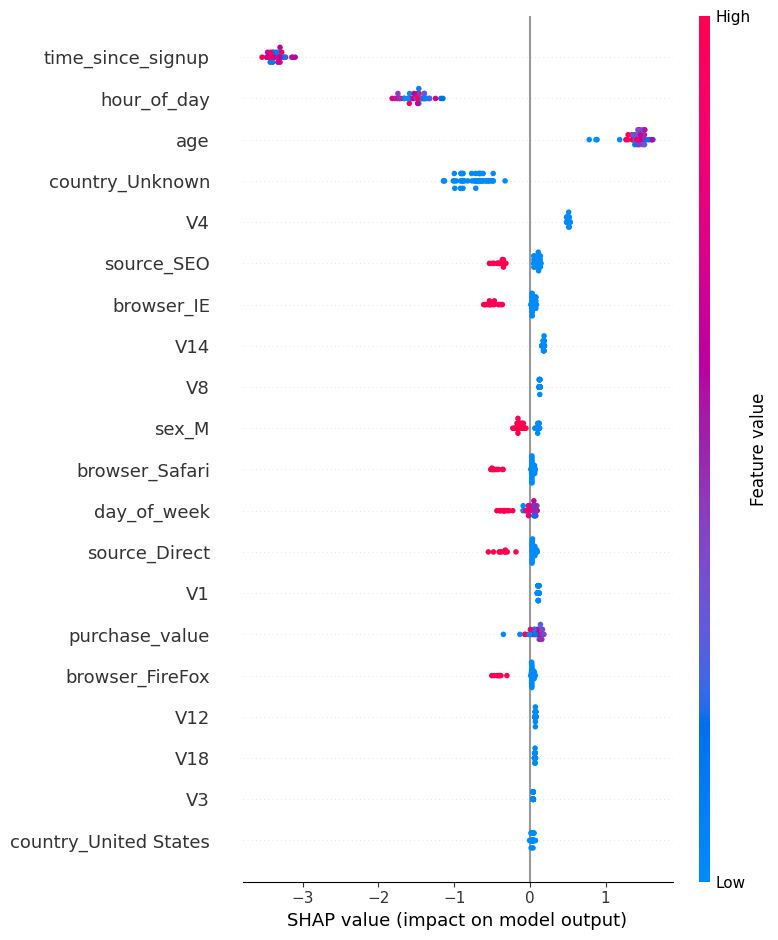

✅ SHAP summary plot saved to: figures\shap_summary.png


In [16]:
def plot_shap_summary(model, X, output_dir):
    print("🔄 Starting SHAP summary plot...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X.iloc[:50])
    print("✅ SHAP values computed.")
    plt.figure()
    shap.summary_plot(shap_values, X.iloc[:50], max_display=20, show=False)
    save_path = os.path.join(output_dir, "shap_summary.png")
    plt.savefig(save_path)
    plt.show()
    print(f"✅ SHAP summary plot saved to: {save_path}")

plot_shap_summary(model, X, output_dir)


## 5: SHAP local waterfall plot (one instance explanation)
This cell creates a detailed waterfall plot for a single instance (the first row in the dataset by default). The waterfall plot breaks down the prediction to show how each feature contributed to pushing the model output from the expected (average) value to the final prediction for this specific example. This is a clear local explanation useful for interpreting individual predictions.


🔄 Starting local waterfall explanation...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


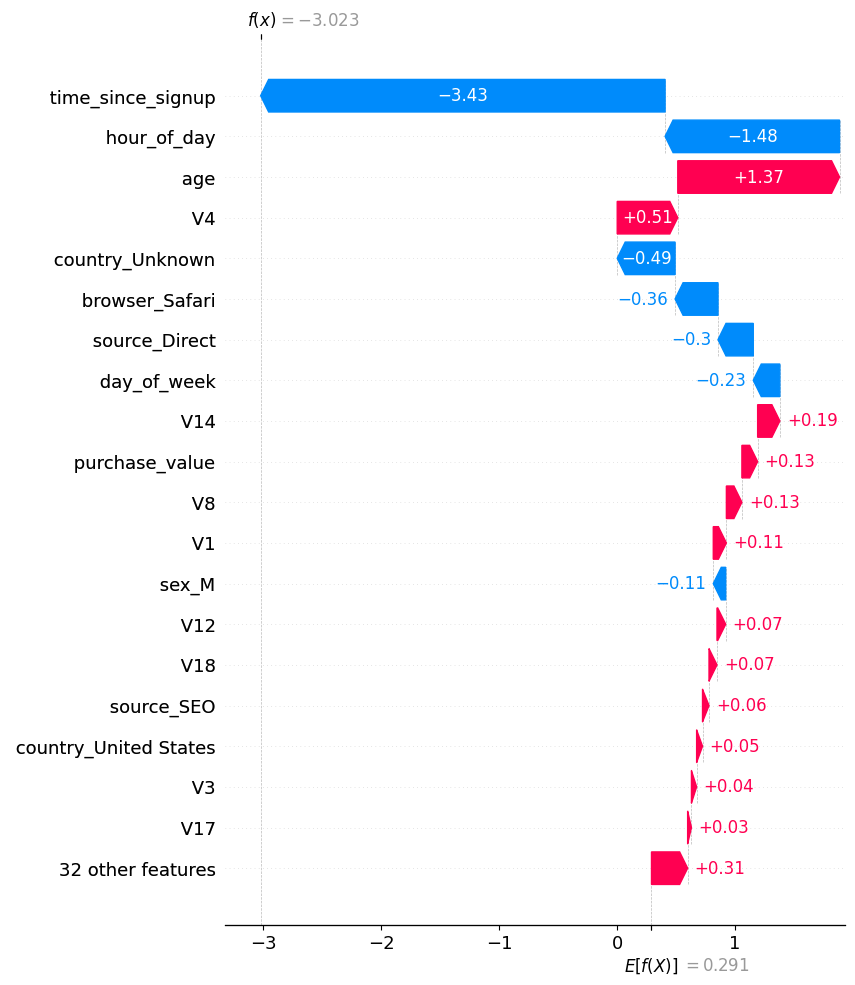

✅ Local waterfall plot saved to: figures\local_waterfall.png


In [17]:
def plot_waterfall(model, X, output_dir):
    print("🔄 Starting local waterfall explanation...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X.iloc[[0]])
    expected_value = explainer.expected_value

    # Binary classification shap_values is a list of arrays for each class
    if isinstance(shap_values, list):
        shap_val_for_plot = shap_values[1][0]
        expected_value = explainer.expected_value[1]
    else:
        shap_val_for_plot = shap_values[0]
        if isinstance(expected_value, (list, np.ndarray)):
            expected_value = expected_value[0]

    plt.figure()
    shap.plots._waterfall.waterfall_legacy(
        expected_value=expected_value,
        shap_values=shap_val_for_plot,
        features=X.iloc[0],
        max_display=20,
        show=False
    )
    save_path = os.path.join(output_dir, "local_waterfall.png")
    plt.savefig(save_path)
    plt.show()
    print(f"✅ Local waterfall plot saved to: {save_path}")

plot_waterfall(model, X, output_dir)


## 6: SHAP force plot (interactive HTML)
Here I generate an interactive SHAP force plot for the same single instance. Unlike static images, this force plot is saved as an HTML file and can be opened in a browser to explore how features collectively influence the prediction. Positive contributions push the prediction higher, negative contributions lower, and the base value is the average model output.

In [18]:
def plot_force_plot(model, X, output_dir):
    print("🔄 Starting SHAP force plot...")
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X.iloc[[0]])

    force_plot = shap.plots.force(
        shap_values.base_values[0],
        shap_values.values[0],
        X.iloc[0],
        matplotlib=False,
        show=False
    )

    save_path = os.path.join(output_dir, "force_plot.html")
    shap.save_html(save_path, force_plot)
    print(f"✅ SHAP force plot saved to: {save_path}")

plot_force_plot(model, X, output_dir)


🔄 Starting SHAP force plot...
✅ SHAP force plot saved to: figures\force_plot.html
